# What drives the price of a car?

![](images/kurt.jpeg)

#### Note
If you are unable to see some of the charts/images - please use <a href="https://github.dev/benharosh/practical_application_2/blob/main/Vehicles.ipynb">this link</a> to see the notebook on github.dev.

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

# CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

 Business Objectives:
 * Dealerships want identify what features in used cars will drive the price of the car up.
 * Dealerships want to have good understanding of what price should they pay for a certain car with certain features, in order to maximize their ability to make profit by buying cars under market value and making profit.
 * Dealerships want to identify which used cars they should stay away from.

Assess Situation -  Assumptions:
* Normally, car year and odometer are the leading factors when assesing used car price. That should suggest that entries without this data pieces should be removed, since we do not want to artificially impute this data, which can lead to inaccurate predictions.
* Used cars prices trend in two directions - prices normally go down when car year gets old, but then in some point old cars become collector cars and then the price of the used car strats to go up as the car is older behind that point.
* The better the condition of the car is, the higher the expected used car price should be. Hence, records without condition data, should be treated cautiously.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [165]:
# in case the following packages are missing please pip install them
# !pip install category_encoders sklearn-pandas feature_engine kaleido

In [166]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import category_encoders as ce
import numpy as np
import time
from matplotlib.pyplot import plot
from feature_engine.imputation import RandomSampleImputer

# sklearn imports
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor, ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn_pandas import DataFrameMapper
from sklearn.utils import estimator_html_repr

# plotly imports
import plotly.express as px
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
# Plotly rendering (work around Plotly rendering issues with GitHub)
pio.renderers.default = "svg"

# init_notebook_mode(connected=True)

In [167]:
df = pd.read_csv('data/vehicles.csv')

In order to get familiar with the data we'll look at the column types and check for missing values and duplicates.

In [168]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

In [169]:
df.head()

id                  region  price  year manufacturer model  \
0  7222695916                prescott   6000   NaN          NaN   NaN   
1  7218891961            fayetteville  11900   NaN          NaN   NaN   
2  7221797935            florida keys  21000   NaN          NaN   NaN   
3  7222270760  worcester / central MA   1500   NaN          NaN   NaN   
4  7210384030              greensboro   4900   NaN          NaN   NaN   

  condition cylinders fuel  odometer title_status transmission  VIN drive  \
0       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
1       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
2       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
3       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   
4       NaN       NaN  NaN       NaN          NaN          NaN  NaN   NaN   

  size type paint_color state  
0  NaN  NaN         NaN    az  
1  NaN  NaN         NaN    ar  
2  NaN  NaN         NaN    fl  
3  NaN  NaN         NaN    ma  
4  NaN  NaN         NaN    nc

In [170]:
print(f"Skewness: {df['price'].skew()}")
print(f"Kurtosis: {df['price'].kurt()}")

Skewness: 254.40693228580142
Kurtosis: 69205.08858968425


We can observe very high values of skewness (to the left since its greater than 1) and kurtosis (outliers).

We can see **many NaN values** at the first records and from the Info summary - we'll try and analyze this and see the portion of each column in our data set.

In [171]:
df_stats = pd.concat([df.isnull().sum(), ((df.isnull().sum()) / len(df)) * 100], axis=1)
df_stats.columns = ['missing count', 'missing %']
df_stats.reset_index()

index  missing count  missing %
0             id              0   0.000000
1         region              0   0.000000
2          price              0   0.000000
3           year           1205   0.282281
4   manufacturer          17646   4.133714
5          model           5277   1.236179
6      condition         174104  40.785232
7      cylinders         177678  41.622470
8           fuel           3013   0.705819
9       odometer           4400   1.030735
10  title_status           8242   1.930753
11  transmission           2556   0.598763
12           VIN         161042  37.725356
13         drive         130567  30.586347
14          size         306361  71.767476
15          type          92858  21.752717
16   paint_color         130203  30.501078
17         state              0   0.000000

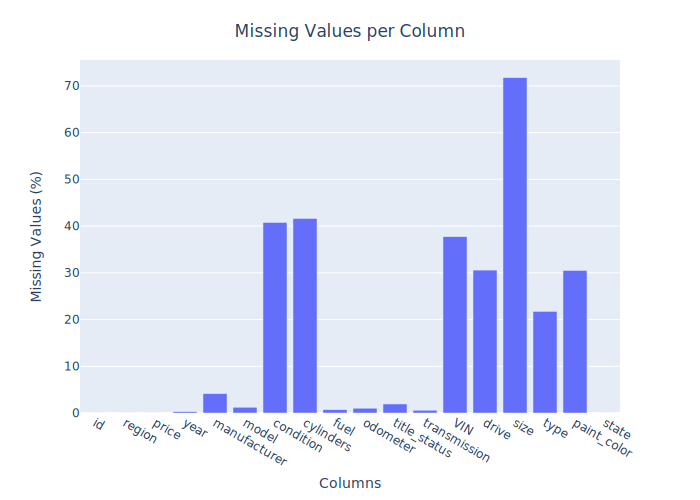

In [172]:
fig = px.bar(df_stats, x=df_stats.index, y='missing %')
fig.update_layout(title='Missing Values per Column',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Missing Values (%)',
                  xaxis_title='Columns')
fig.show()

#### Analyzing Numerical columns

#### Price analysis

In [173]:
df.describe()

id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07

In [174]:
df_price_up_to_1M = df[(df['price'] >= 0) & (df['price'] < 1000000)]
df_price_up_to_200k = df[(df['price'] >= 0) & (df['price'] <= 200000)]
df_price_up_to_100k = df[(df['price'] >= 0) & (df['price'] <= 100000)]


trace1 = go.Box(
    y=df['price'].to_list(),
    name='Car Price (All)'
)

trace2 = go.Box(
    y=(df_price_up_to_1M['price']).to_list(),
    name='Car Price under 1 Million (USD)'
)

trace3 = go.Box(
    y=(df_price_up_to_200k['price']).to_list(),
    name='Car Price under 200K (USD)'
)

fig = make_subplots(rows=1, cols=3)
fig.append_trace(trace1, row = 1, col = 1)
fig.append_trace(trace2, row = 1, col = 2)
fig.append_trace(trace3, row = 1, col = 3)
fig.update_layout(width=1000, showlegend=True, title='Car Price BoxPlots', title_x=0.4, title_y=0.9)

fig.show()

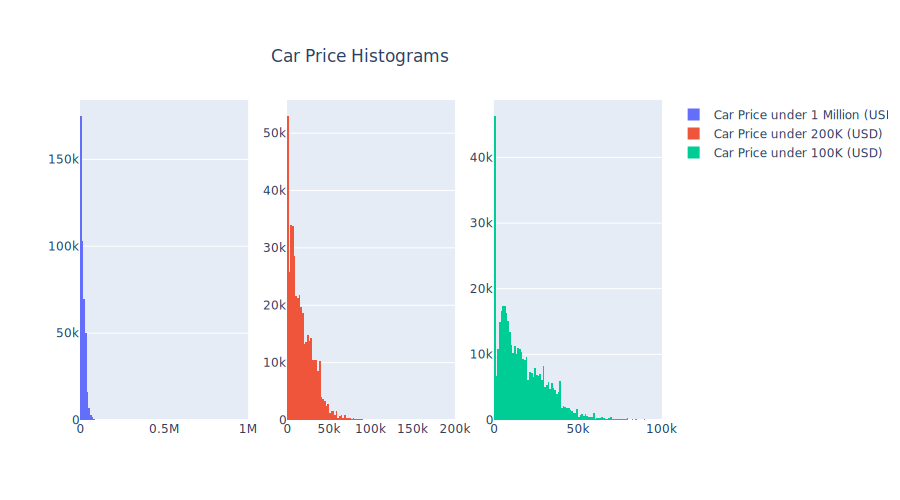

In [175]:
trace1 = go.Histogram(
    x=(df_price_up_to_1M['price']).to_list(),
    xbins=dict(
        start=0, end=1000000,
        size=10000),
    autobinx=False,
    name='Car Price under 1 Million (USD)'
)

trace2 = go.Histogram(
    x=(df_price_up_to_200k['price']).to_list(),
    xbins=dict(
        start=0, end=200000,
        size=2000),
    autobinx=False,
    name='Car Price under 200K (USD)'
)

trace3 = go.Histogram(
    x=(df_price_up_to_100k['price']).to_list(),
    xbins=dict(
        start=0, end=100000,
        size=1000),
    autobinx=False,
    name='Car Price under 100K (USD)'
)

fig = make_subplots(rows=1, cols=3)
fig.append_trace(trace1, row = 1, col = 1)
fig.append_trace(trace2, row = 1, col = 2)
fig.append_trace(trace3, row = 1, col = 3)
fig.update_layout(width=900, showlegend=True, title='Car Price Histograms', title_x=0.4, title_y=0.9)

fig.show()

Seems like we have some price outliers, that are in the billions and some outliers aroung price = 0. We'll try to focus on getting most of the car prices while dropping the outliers. Lets focus on cars that are more than `$500` and less than `$100K`, that seems to capture most of the data.  

Prices seems to be still skewed to the left. We should consider using a log function to have a more evenly distributed values.

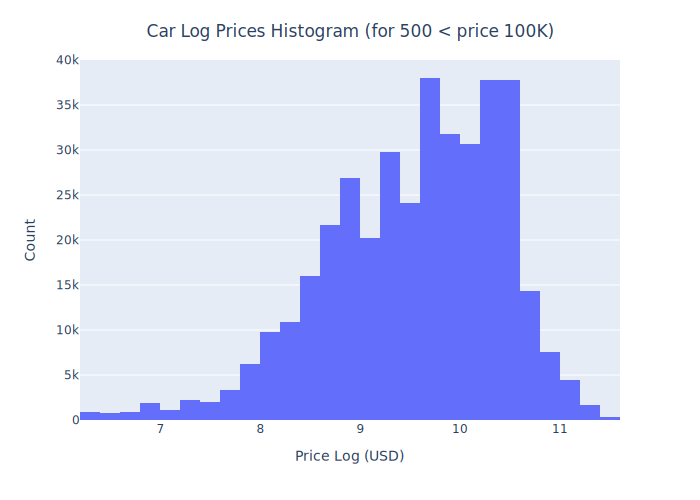

Car priced $500 to $100K are 89.74% of the original data set


In [176]:
# we'll show the distribution of the log of the price in boundaries of 500 to 100K
df_price_boundaries = df[(df['price'] > 500) & (df['price'] < 100000)]
fig = px.histogram(df_price_boundaries, x=np.log(df_price_boundaries['price']), nbins=50)
fig.update_layout(title='Car Log Prices Histogram (for 500 < price 100K)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Price Log (USD)')
fig.show()
print(f'Car priced $500 to $100K are {"%.2f"%((len(df_price_boundaries) / len(df)) * 100)}% of the original data set')

Seems like we can capture most of the data for car prices between 500 and 100K (USD) - almost 90%.

In [177]:
df_price_boundaries['df_price_boundaries']=np.log(df_price_boundaries['price'])
print(f"Skewness: {df_price_boundaries['df_price_boundaries'].skew()}")
print(f"Kurtosis: {df_price_boundaries['df_price_boundaries'].kurt()}")

Skewness: -0.6710176194506454
Kurtosis: 0.30210742396586054


After setting price boundaries and applying log to the price the skewiness of the price is a little bit to the right but well under control as we can see in the plot above. For skewness values between -0.5 and 0.5, the data exhibit approximate symmetry. Kurtosis is way more controlled now and is < 3 which means platykurtic - the distribution is flatter (less peaked) when compared with the normal distribution.

#### Odometer analysis

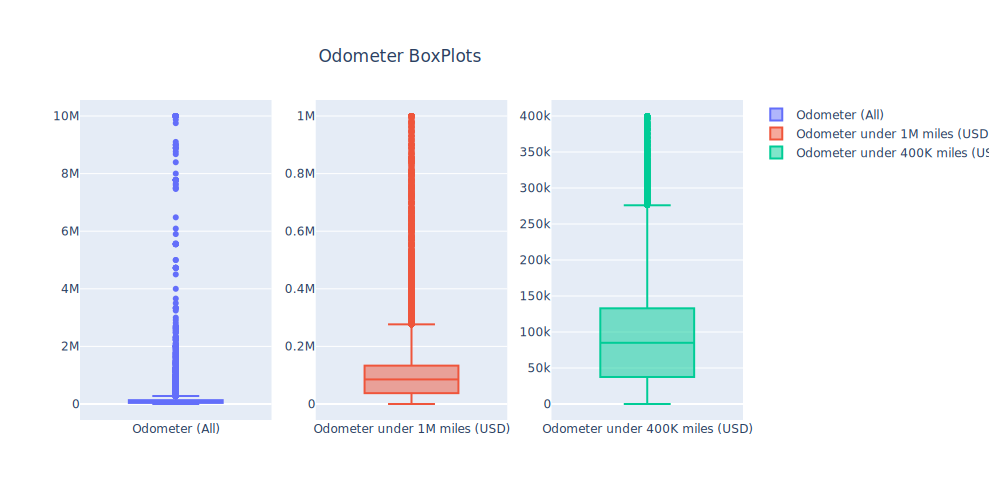

In [178]:
df_odo_up_to_1M = df[(df['odometer'] >= 0) & (df['odometer'] <= 1000000)]
df_odo_up_to_400k = df[(df['odometer'] >= 0) & (df['odometer'] <= 400000)]


trace1 = go.Box(
    y=df['odometer'].to_list(),
    name='Odometer (All)'
)

trace2 = go.Box(
    y=(df_odo_up_to_1M['odometer']).to_list(),
    name='Odometer under 1M miles (USD)'
)

trace3 = go.Box(
    y=(df_odo_up_to_400k['odometer']).to_list(),
    name='Odometer under 400K miles (USD)'
)

fig = make_subplots(rows=1, cols=3)
fig.append_trace(trace1, row = 1, col = 1)
fig.append_trace(trace2, row = 1, col = 2)
fig.append_trace(trace3, row = 1, col = 3)
fig.update_layout(width=1000, showlegend=True, title='Odometer BoxPlots', title_x=0.4, title_y=0.9)

fig.show()

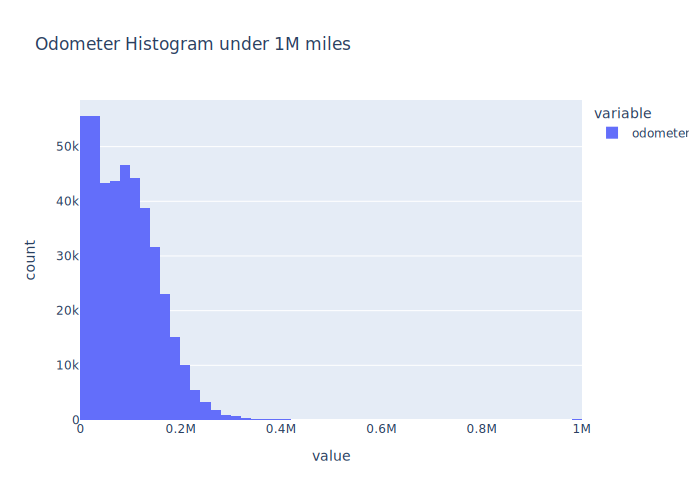

In [179]:
df_low_odo = df[df['odometer'] < 1000000]
fig = px.histogram(df_low_odo['odometer'], nbins=50, title='Odometer Histogram under 1M miles')
fig.show()

We can see that there are very few car that their odometer is over 400K miles. Normally cars will not reach odometer values above 400K miles, so we can consider removing those as outliers, and because they probably represent wrong data collection (some odometer records has 10M miles values).

#### Analyzing Categorical columns


We'll look at the object types and see their meta data. We'll see how many unique values each category has and some mean/median values for numerical features.

In [180]:
# describe categorical feature meta data
df.describe(include = ['object'])

region manufacturer   model condition    cylinders    fuel  \
count     426880       409234  421603    252776       249202  423867   
unique       404           42   29649         6            8       5   
top     columbus         ford   f-150      good  6 cylinders     gas   
freq        3608        70985    8009    121456        94169  356209   

       title_status transmission                VIN   drive       size  \
count        418638       424324             265838  296313     120519   
unique            6            3             118246       3          4   
top           clean    automatic  1FMJU1JT1HEA52352     4wd  full-size   
freq         405117       336524                261  131904      63465   

          type paint_color   state  
count   334022      296677  426880  
unique      13          12      51  
top      sedan       white      ca  
freq     87056       79285   50614

There's a `VIN` number that repeats 261 time in the data set. That suggests that there are duplicates for certain `VIN` number's. We'll take a further look at that. We can also see **29K unique values for `model` column**, which will be very hard to encode as category and we might want to consider to drop this column.

In [181]:
(df[df['VIN'] == '1FMJU1JT1HEA52352']).sample(5)

id            region  price    year manufacturer  \
288576  7311822876         ashtabula  29590  2017.0         ford   
287065  7311883703    akron / canton  29590  2017.0         ford   
357432  7311817991           memphis  29590  2017.0         ford   
60039   7311766813       santa maria  29590  2017.0         ford   
139731  7311848463  champaign urbana  29590  2017.0         ford   

                       model condition    cylinders fuel  odometer  \
288576  expedition xlt sport      good  6 cylinders  gas   70760.0   
287065  expedition xlt sport      good  6 cylinders  gas   70760.0   
357432  expedition xlt sport      good  6 cylinders  gas   70760.0   
60039   expedition xlt sport      good  6 cylinders  gas   70760.0   
139731  expedition xlt sport      good  6 cylinders  gas   70760.0   

       title_status transmission                VIN drive size type  \
288576        clean        other  1FMJU1JT1HEA52352   4wd  NaN  SUV   
287065        clean        other  1FMJU1JT1HEA52352   4wd  NaN  SUV   
357432        clean        other  1FMJU1JT1HEA52352   4wd  NaN  SUV   
60039         clean        other  1FMJU1JT1HEA52352   4wd  NaN  SUV   
139731        clean        other  1FMJU1JT1HEA52352   4wd  NaN  SUV   

       paint_color state  
288576        blue    oh  
287065        blue    oh  
357432        blue    tn  
60039         blue    ca  
139731        blue    il

We can clearly see that the same car (same VIN, odometer, year) has several duplicate entries that only differ in `region` or `state` values.

In [182]:
df['VIN'].sort_values().value_counts()

VIN
1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
                    ... 
1FTNX20F0XEB86525      1
3GCUKSEC1HG126272      1
3GCUKSEC1GG192397      1
3GCUKSEC1FG473887      1
3C6TRVBG4GE133590      1
Name: count, Length: 118246, dtype: int64

We can see that many VIN numbers have duplicates. We'll clean them during the Data Preparation stage.

In [183]:
df['region'].unique().size

404

`region` has many unique values and we should keep it or drop it for simplifying our model fitting process.

In [184]:
conditions = df['condition'].unique()
cylinders = df['cylinders'].unique()
print(f'cylinders values = {cylinders}')
print(f'condition values = {conditions}')

cylinders values = [nan '8 cylinders' '6 cylinders' '4 cylinders' '5 cylinders' 'other'
 '3 cylinders' '10 cylinders' '12 cylinders']
condition values = [nan 'good' 'excellent' 'fair' 'like new' 'new' 'salvage']


`condition` and `cylinders` can both seem to possibly have ordinality with their values. We should consider encoding them with OrdinalEncoder with pre-processing them. Also, we should consider dropping `other` values and treat them as missing values.

### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

#### Dropping `size` and `id` columns

There are many missing values with 5 columns missing more than `30%` of their data, we'll have to decide what colums do we drop, what rows do we drop and and what columns do we impute.

In [185]:
# Dropping the size column since it's missing most of its values (71.77%)
df.drop(['size'], axis=1, inplace=True)

In [186]:
# Dropping `id` since the  column hold a unique identifier that will not assist in prediction
df.drop(['id'], axis=1, inplace=True)

#### Dropping Duplicates


We'll remove duplicates by comparing all columns

In [187]:
# dictionary holder to track data cleaning values
cleanup_data = {'categories': [], 'values': []}

In [188]:
before = len(df)
print(f'dataframe size before removing duplicates: {before}')
df = df.drop_duplicates()
print(f'dataframe size after removing duplicates: {len(df)}')
cleanup_data['categories'].append('duplicate records')
cleanup_data['values'].append(before - len(df))

dataframe size before removing duplicates: 426880
dataframe size after removing duplicates: 370603


#### Dropping VIN Duplicates

After seeing earlier that there's a VIN number that repeats 261 time in the data set, we'll want to investigate that point. Looking at the `value_counts` of the `VIN` column shows that many entries - which only differ by the `region` or `state` - are duplicates. These duplicates that should be removed, because they essentially represent the same data.

In [189]:
df['VIN'].sort_values().value_counts().head(5)

VIN
1FMJU1JT1HEA52352    261
3C6JR6DT3KG560649    235
1FTER1EH1LLA36301    231
5TFTX4CN3EX042751    227
1GCHTCE37G1186784    214
Name: count, dtype: int64

In [190]:
# Dropping duplicates by ['year', 'manufacturer', 'condition', 'odometer', 'VIN'] combination
before = len(df)
print(f'dataframe size before removing VIN duplicates: {before}')
duplicated = df.loc[df.duplicated(['year', 'manufacturer', 'condition', 'odometer', 'VIN'], keep='last')]
df = df.drop(duplicated.index, axis=0)
print(f'dataframe size after removing VIN duplicates: {len(df)}')
print(f'By removing VIN duplicated we removed {((before - len(df)) / before) * 100 }% of the data')
cleanup_data['categories'].append('duplicate VIN records')
cleanup_data['values'].append(before - len(df))

dataframe size before removing VIN duplicates: 370603
dataframe size after removing VIN duplicates: 227852
By removing VIN duplicated we removed 38.51857648211159% of the data


We can see that big portion of our initial data set was VIN duplicates (`38.51%`)

#### Removing `odometer` outliers

We'll focus on `odometer` records under 400,000 miles - the rest will be outliers that can affect prediction accuracy (some `odometer` values above 400,000 doesn't seem to be real)

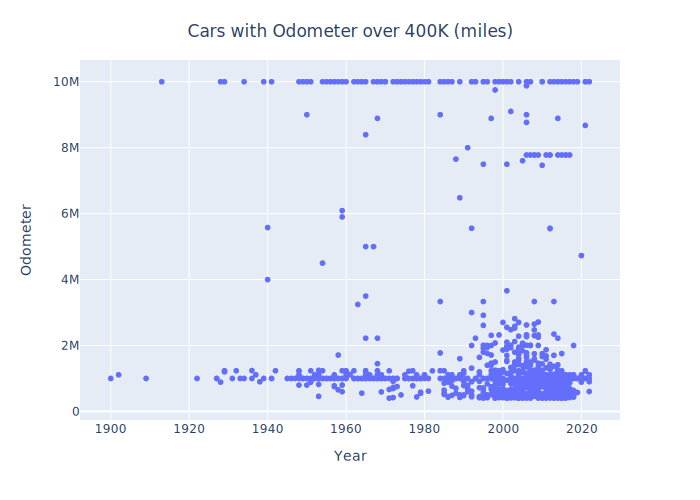

In [191]:
df_odo = df[(df['odometer'] > 400000)]
fig = px.scatter(x=df_odo['year'], y=df_odo['odometer'])
fig.update_layout(title='Cars with Odometer over 400K (miles)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Odometer',
                  xaxis_title='Year')
fig.show()

We can clearly see some wrong odometer values between 500K and 10M miles, and it doesn't even correlate to how old is the vehicle. Hence, we'll remove these outliers.

In [192]:
before = len(df)
print(f'dataframe size before removing odometer outliers: {before}')
df = df[(df['odometer'] <= 400000)]
print(f'dataframe size after removing odometer outliers: {len(df)}')
cleanup_data['categories'].append('high odometer cleanup')
cleanup_data['values'].append(before - len(df))

dataframe size before removing odometer outliers: 227852
dataframe size after removing odometer outliers: 224521


In [193]:
df_stats = pd.concat([df.isnull().sum(), ((df.isnull().sum()) / len(df)) * 100], axis=1)
df_stats.columns = ['missing count', 'missing percent']
df_stats

missing count  missing percent
region                    0         0.000000
price                     0         0.000000
year                    594         0.264563
manufacturer           9352         4.165312
model                  3157         1.406105
condition             89120        39.693392
cylinders             79176        35.264407
fuel                   1304         0.580792
odometer                  0         0.000000
title_status           3457         1.539722
transmission            879         0.391500
VIN                  106380        47.380869
drive                 62298        27.747070
type                  54783        24.399945
paint_color           65469        29.159410
state                     0         0.000000

*   Dropping columns that provide no meaning for prediction as `VIN` numbers (as similar to `id` we dropped earlier).
*   Dropping columns with high number of categorical values as `model` and `region` and `state` in order to make prediction pipeline relatively concise.







In [194]:
df = df.drop(['VIN', 'model'], axis=1)

We'll take a look at the price distribution

#### Removing car price outliers
In Data Understanding phase we saw that we have some price outliers with prices in the billions, lets remove them. We will also remove cars with price = 0, and other outliers, to focus on predicting prices of cars between 500 and 100K, which represents most of the cars that were reported in this data set (over `90%`).

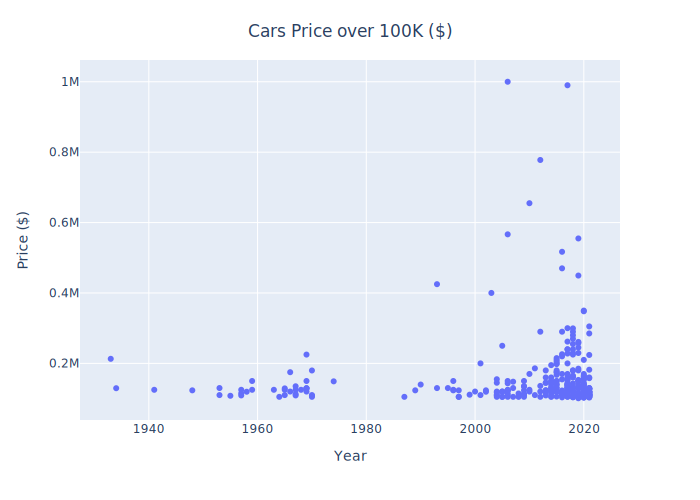

In [195]:
df_price = df[(df['price'] > 100000) & (df['price'] < 1000000)]
fig = px.scatter(x=df_price['year'], y=df_price['price'])
fig.update_layout(title='Cars Price over 100K ($)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Price ($)',
                  xaxis_title='Year')
fig.show()

We can see a very interesting trend - newer cars from the 1990, and old cars before 1970 had cars priced over 100K (USD). 

data set size before removing `price` outliers = 224521
data set size after removing `price` outliers = 204102
for the price range 500 < price < 100000 kept 90.91% of records


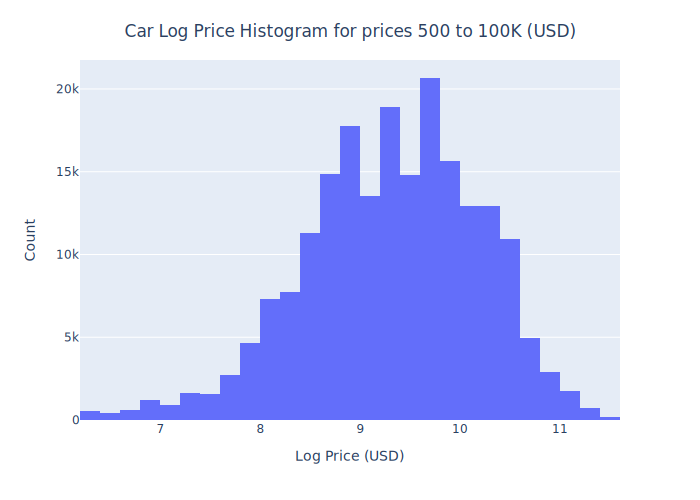

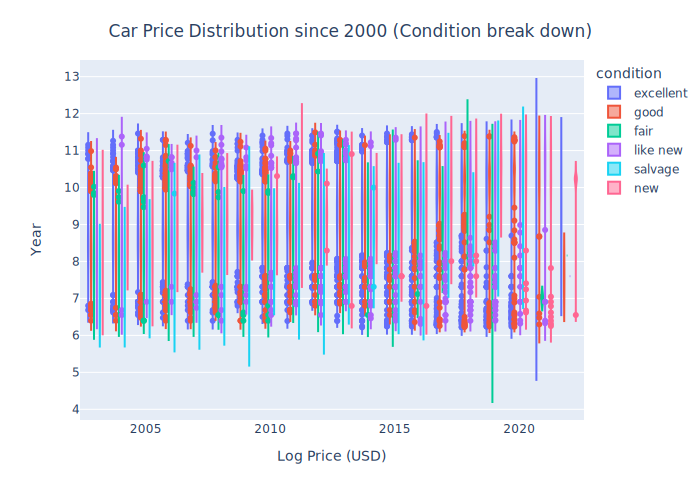

In [196]:
# Remove outliers for price < 500 or price > 100,000 - to mainly remove cars with pricing issues
before = len(df)
print(f'data set size before removing `price` outliers = {before}')
df = df[(df['price'] > 500) & (df['price'] <= 100000)]
print(f'data set size after removing `price` outliers = {len(df)}')
print(f'for the price range 500 < price < 100000 kept {"%.2f"%((len(df) / before) * 100)}% of records')
cleanup_data['categories'].append('car price cleanup')
cleanup_data['values'].append(before - len(df))

fig = px.histogram(df, x=np.log(df['price']), nbins=50)
fig.update_layout(title='Car Log Price Histogram for prices 500 to 100K (USD)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Log Price (USD)')
fig.show()

df5 = df[df['year'] > 2002]
fig = px.violin(df5, x="year", y=np.log(df5['price']), color='condition')
fig.update_layout( title='Car Price Distribution since 2000 (Condition break down)',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Year',
                  xaxis_title='Log Price (USD)')
fig.show()

We can see the **`price` log gives us a better price distribution** and we'll use a target transformer as part of building the model to reflect this understanding for better predictions.

#### Cleaning title status category

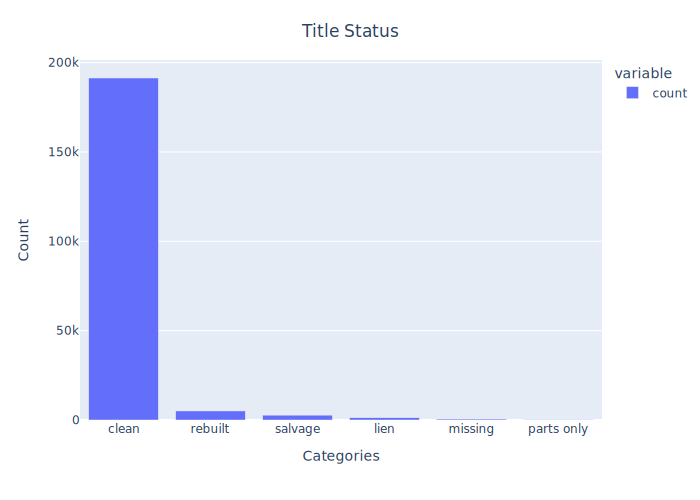

clean title precentage in the data set = 93.772% ,so we will remove the rest of the categories and focus on predicting car prices for cars with clean titles.


In [197]:
fig = px.bar(df['title_status'].value_counts())
fig.update_layout(title='Title Status',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='Count',
                  xaxis_title='Categories')
fig.show()
clean_title_count = len(df[df['title_status'] == 'clean'])
print(f'clean title precentage in the data set = {"%.3f"%((clean_title_count / len(df)) * 100)}%' \
     ' ,so we will remove the rest of the categories and focus on predicting car prices for cars with clean titles.')

In [198]:
before = len(df)
print(f'data set before cleaning "title_status" = {before}')
df = df[df['title_status'] == 'clean']
# only 1 value left in the title status column - so we can remove it for the prediction part
df.drop(['title_status'], axis=1, inplace=True)
print(f'data set size after cleaning "title_status" = {len(df)}')
cleanup_data['categories'].append('title_status cleanup')
cleanup_data['values'].append(before - len(df))

data set before cleaning "title_status" = 204102
data set size after cleaning "title_status" = 191390


#### Removing Rows that have high number of columns with NaN values
Removing NaN values where `condition`, `paint_color`, `drive`, `cylinders` and `type` columns (which are missing more than 30% of their data) - are missing data at the same row, in order to not impute too many values and generate data which is mostly syntetic.

In [199]:
columns_to_clean = ['condition', 'paint_color', 'drive', 'cylinders', 'type']
before = len(df)
print(f'data set before cleaning rows with 5 NaN values for = {before}')
NaNs_in_5_columns = df.loc[df[columns_to_clean].isna().all(1)]
print(f'found {len(NaNs_in_5_columns)} rows to clean')
df = df.drop(NaNs_in_5_columns.index, axis=0)
print(f'data set after cleaning rows with 5 NaN values for = {len(df)}')
cleanup_data['categories'].append('5 NaNs cleanup')
cleanup_data['values'].append(before - len(df))


data set before cleaning rows with 5 NaN values for = 191390
found 18031 rows to clean
data set after cleaning rows with 5 NaN values for = 173359


With similar logic, removing rows where 4 features are missing their values (out of the 5 features with most missing values ['condition', 'paint_color', 'drive', 'cylinders', 'type']).

In [200]:
# removing rows where 4 features are missing
before = len(df)
print(f'data set before cleaning rows with 4 NaN values for = {before}')
filtered_data_1 = df.loc[df['paint_color'].isna() & df['drive'].isna() & df['cylinders'].isna() & df['type'].isna()]
filtered_data_2 = df.loc[df['condition'].isna() & df['drive'].isna() & df['cylinders'].isna() & df['type'].isna()]
filtered_data_3 = df.loc[df['paint_color'].isna() & df['condition'].isna() & df['cylinders'].isna() & df['type'].isna()]
filtered_data_4 = df.loc[df['paint_color'].isna() & df['condition'].isna() & df['drive'].isna() & df['type'].isna()]
filtered_data_5 = df.loc[df['paint_color'].isna() & df['condition'].isna() & df['drive'].isna() & df['cylinders'].isna()]
for data in [filtered_data_1, filtered_data_1, filtered_data_3, filtered_data_3, filtered_data_4, filtered_data_5 ]:
    df = df.drop(data.index, errors='ignore', axis=0)

len(df)

cleanup_data['categories'].append('4 NaNs cleanup')
cleanup_data['values'].append(before - len(df))

data set before cleaning rows with 4 NaN values for = 173359


#### Removing Rows with `other` values

Removing rows where values is 'other' - we'll treat `other` as a missing value since it can be replaced by any other categorical value, including NaN, and may affect the ability to predict accurately the target price.

In [201]:
# treating 'other' as missing value
before = len(df)
print(f'data set size before cleaning "other" values = {before}')
other_status = df.loc[(df['condition'] == 'other') |  (df['cylinders'] == 'other') | (df['type'] == 'other') | (df['fuel'] == 'other')]
df = df.drop(other_status.index, axis=0)
print(f'data set size after cleaning "other" values = {len(df)}')
cleanup_data['categories'].append('other cleanup')
cleanup_data['values'].append(before - len(df))

data set size before cleaning "other" values = 165205
data set size after cleaning "other" values = 153910


In [202]:
print('missing values percentage:')
((df.isnull().sum()) / len(df)) * 100

missing values percentage:


region           0.000000
price            0.000000
year             0.239101
manufacturer     3.860048
condition       29.945423
cylinders       22.294198
fuel             0.625041
odometer         0.000000
transmission     0.329413
drive           14.609187
type            14.509778
paint_color     15.097784
state            0.000000
dtype: float64

#### Removing NaN values for colums with less than 4% of missing values
From the above table we can see that ['year', 'odometer', 'manufacturer', 'fuel', 'transmission'] columns are missing less than 4% of their values, so we'll remove these values.

In [203]:
before = len(df)
print(f'data set size before cleaning NaN values = {before}')
colums_to_clean_NaNs = ['year', 'odometer', 'manufacturer', 'fuel', 'transmission']
print(f'dropping missing values percentage for {colums_to_clean_NaNs}')
df.dropna(subset=colums_to_clean_NaNs, inplace=True)
print(f'data set size after cleaning NaN values = {len(df)}')
cleanup_data['categories'].append('NaNs low count cleanup')
cleanup_data['values'].append(before - len(df))

data set size before cleaning NaN values = 153910
dropping missing values percentage for ['year', 'odometer', 'manufacturer', 'fuel', 'transmission']
data set size after cleaning NaN values = 146579


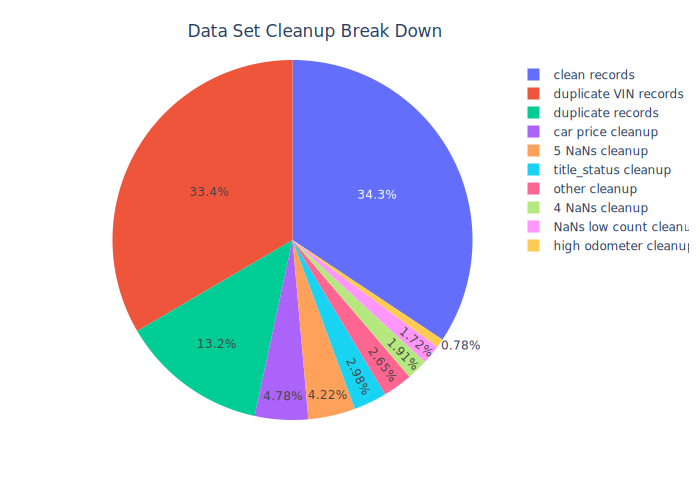

In [204]:
cleanup_data['categories'].append('clean records')
cleanup_data['values'].append(len(df))

cleanup_data_df = pd.DataFrame(cleanup_data)
cleanup_data_df.head(10)
fig = px.pie(cleanup_data_df, values='values', names='categories')
fig.update_layout(title='Data Set Cleanup Break Down',
                  title_x=0.45, title_y=0.95)
fig.show()

Clean records (before imputation) are 34.3% of the original data set. Most of the cleanup was done around duplicate VIN records, duplicate records and setting price boundaries (especially removing cars with price = 0)

#### Correlation Matrix for numerical values


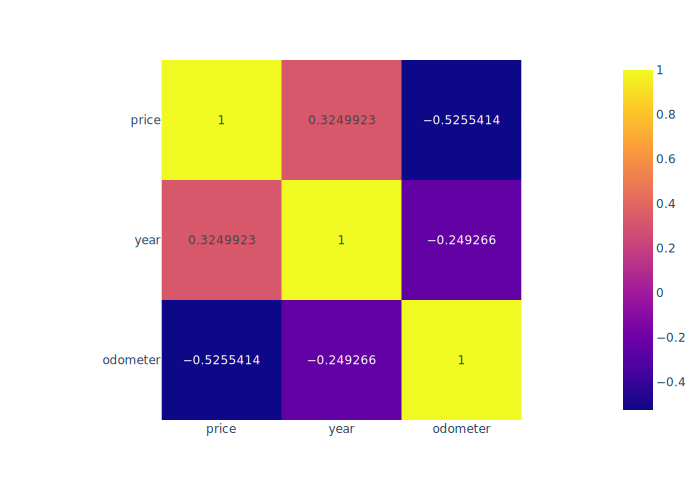

In [205]:
fig = px.imshow(df[['price', 'year', 'odometer']].corr(),  text_auto=True)
fig.show()

After cleaning the data, we can see a **strong negative correlation between the `price` and the `odometer`** - the higher the odometer milage - the lower the price of the car would be. 
We can also see a positive correlation between `year` and `price`. Since collectors cars with old years tend to have greater value, we can try and see if we'll get better correlation between `year` and `price` with newer cars.

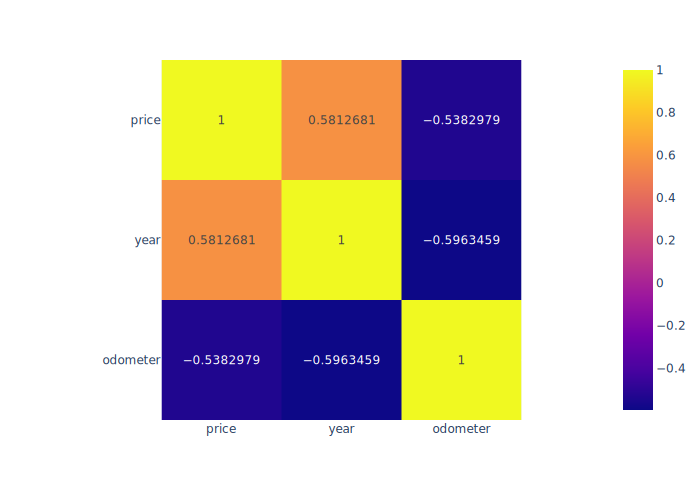

In [206]:
df_numeric = df[['price', 'year', 'odometer']]
fig = px.imshow(df_numeric[df_numeric['year'] > 1990].corr(),  text_auto=True)
fig.show()

And we can see that **newer cars have stonger positive correlation between `year` and `price`**

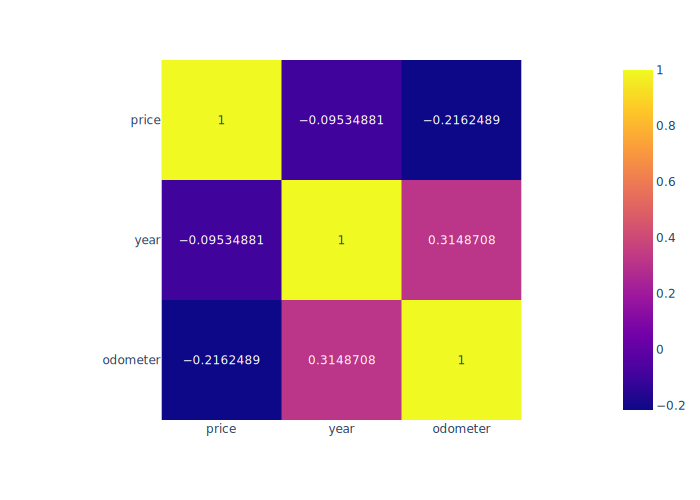

In [207]:
# analyzing cars before 1970
fig = px.imshow(df_numeric[df_numeric['year'] < 1970].corr(),  text_auto=True)
fig.show()

And we can see that **older cars have weak/no correlation between `year` and `price`**. It's also interesting to see that **the correlation between `odometer` and `price` got weaker for older cars.**

#### Data Imputation strategy
We'll generate an instance of RandomSampleImputer and we'll later use it for data imputation for columns that are missing most their data - ['condition', 'cylinders', 'drive', 'type','paint_color']. I chose this imputer because it's fast and keeping the same distribution of data before and after imputation, which is very important when imputing 20-30% of missing data.

In [208]:
rand_sample_imputer = RandomSampleImputer(

    # the variables to impute
    variables=['condition', 'cylinders', 'drive', 'type', 'paint_color'],

    # the random state for reproducibility
    random_state=10,

    # equialent to setting random_state in
    # pandas.sample()
    seed='general'
)
rand_sample_imputer

RandomSampleImputer(random_state=10,
                    variables=['condition', 'cylinders', 'drive', 'type',
                               'paint_color'])

### Modeling

With our final dataset in hand (before imputation), we'll now build some models.  We'll build a number of different regression models with the price as the target.  In building the models, we'll explore different hyper parameters and cross-validate our findings with **K-Fold cros-validation** on the training data, and also conduct a **Holdout cross-validation** on the best model the K-folded suggested with different sizes of hold-out set (80/20, 72/25, 70/30).

![](images/holdout-crossvalidation.png)

#### Building the Preprocessing Pipelines and ColumnTransformer
I created 4 pipelines for 4 different types of data that I observed:
* **numerical columns** that are left in the data set [year, odometer] - will go through a scaler and a polynomial features in order to build multiple regression model.
* **categorical columns that has no ordinality** - will go through imputation with RandomSampleImputer and then encoding with JamesSteinEncoder that will keep the number of columns concise without the need to generate dummy columns.
* **categorical columns that has ordinality** [condition, cylinders] - will go though imputation with  RandomSampleImputer and then encoding with OrdinalEncoder which will get ordered values for each of the columns.
* **categorical columns with low number of categories** [fuel, drive] were candidate for OneHotEncoder without adding the overhead of too many additional columns for the dummy values when splitting their values in unique columns. They will go through imputation with RandomSampleImputer and then encoding with OneHotEncoder.

In [209]:
cat_features = df.select_dtypes(exclude=['int', 'float'])
condition_cat = ['salvage', 'fair','good', 'excellent','like new', 'new']
cylinders_cat = ['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders']

ord_enc = OrdinalEncoder(categories=[condition_cat, cylinders_cat])

# numerical columns
numeric_features = ['year', 'odometer']
transformer1 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])
# categorical columns that has no ordinality 
transformer2 = Pipeline(steps=[
    ('imputer', RandomSampleImputer(random_state=10, seed='general')),
    ('encoder', ce.JamesSteinEncoder())
])
# categorical columns that has ordinality
ord_enc_feat = ['condition', 'cylinders']
transformer3 = Pipeline(steps=[
    ('imputer', RandomSampleImputer(random_state=10, seed='general')),
    ('encoder', ord_enc)
])
#categorical columns with low number of categories
ohe_enc_feat = ['fuel', 'drive']
transformer4 = Pipeline(steps=[
    ('imputer', RandomSampleImputer(random_state=10, seed='general')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# categorical columns that has no ordinality - will be all categorical columns minus 
# those that have ordinality or those that we decided to hot encode 
categorical_features = list(cat_features.columns)
categorical_features.remove(ord_enc_feat[0])
categorical_features.remove(ord_enc_feat[1])
categorical_features.remove(ohe_enc_feat[0])
categorical_features.remove(ohe_enc_feat[1])

# building the final preprocessing transformer and specifying the columm mapping
transformer = ColumnTransformer(
    transformers=[
        ('numeric_transformer', transformer1, numeric_features),
        ('categorical_transformer', transformer2, categorical_features),
        ('ordinal_transformer', transformer3, ord_enc_feat),
        ('ohe_transformer', transformer4, ohe_enc_feat)
    ], remainder='passthrough')

#### GridSearch with different test set sizes and cross-validation
After building the preprocessing pipelines, we'll conduct a GridSearchCV to find the best hyper parameters with 3 different test set sizes (defaults to test sizes of `[0.2, 0.25, 0.3]`) and an input cross-validation method. I created a function that will ease the GridSearchCV process.

In [210]:
def grid_cv_search_dif_test_sizes(X, y, model, params, impute_needed=False, test_set_size = [0.2, 0.25, 0.3], cv_input=5, verbose=False):
  best_test_mse = np.Infinity
  best_train_mse = np.Infinity
  best_model = np.NaN
  best_params = np.NaN
  best_score = np.Infinity
  best_r2 = np.Infinity

  # run grid search for each test size split
  for test_sz in test_set_size:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=42)

    if impute_needed == True:
        X_test = rand_sample_imputer.fit_transform(X_test)

    grid = GridSearchCV(model, param_grid=params, cv=cv_input, verbose=1).fit(X_train, y_train)

    best_model =  grid.best_estimator_
    train_preds = best_model.predict(X_train)
    test_preds = best_model.predict(X_test)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)
    r2 = r2_score(y_test, test_preds)

    best_score = grid.best_score_

    if verbose == True:
        print(f'best params for test size {test_sz} = {grid.best_params_}')
        print(f'train_mse for test size {test_sz} = {train_mse}')
        print(f'test_mse for test size {test_sz} = {test_mse}')
        print(f'r2 for test size {test_sz} = {r2}')
        print(f'GridSearchCV best MSE for test size {test_sz} = {best_score}')

    if test_mse < best_test_mse:
      best_test_mse = test_mse
      best_train_mse = train_mse
      best_model = grid.best_estimator_
      best_score = grid.best_score_
      best_params = grid.best_params_
      best_test_size = test_sz
      best_r2 = r2
    else:
      continue

  return best_test_mse, best_train_mse, best_model, best_params, best_score, best_r2, best_test_size

#### Defining dictionaries for model and permutation importance results
In order to later compare results across different models, we'll create dictionaries that will hold the model performance results and the features permutation importance. I also generated functions to ease the calculation of these matrices during the models assesemnt.

In [211]:
# place holder for best model results for each model that we are testing
model_results = {'regressor': [], 'method': [], 'grid_params':[], 'train_mse': [], 'test_mse': [], 'r_2':[], 'test_size':[]}

# holder for permutation importance results
permutation_importance_results = {'feature': [], 'importance_mean': [], 'importance_std': [], 'model':[]}

In [212]:
# updating the model_results dictionary with a given model performance - r2, test and train mses and optimal test size (for hold-out set)
def update_model_results(regressor, method, params, train_mse, test_mse, r_2, test_size):
  model_results['regressor'].append(regressor)
  model_results['method'].append(method)
  model_results['grid_params'].append(params)
  model_results['train_mse'].append(train_mse)
  model_results['test_mse'].append(test_mse)
  model_results['r_2'].append(r_2)
  model_results['test_size'].append(test_size)
  df3 = pd.DataFrame(model_results)

  df_ridge_no_nans = df3[(df3['regressor'] == regressor) & (df3['method'] == method)]
  print(df_ridge_no_nans.head(10))
  print(f'best params = {params}')

In [213]:
# define a generic function for calculating permutation importance
def calc_permutation_importance(model, X, y, model_name, n_repeats=10, random_state=0):
  r = permutation_importance(best_model, X, y, n_repeats=10, random_state=0)
  for i in r.importances_mean.argsort()[::-1]:
      permutation_importance_results['feature'].append(X.columns.tolist()[i])
      permutation_importance_results['importance_mean'].append(r.importances_mean[i])
      permutation_importance_results['importance_std'].append(r.importances_std[i])
      permutation_importance_results['model'].append(model_name)

  df2 = pd.DataFrame(permutation_importance_results)
  df2[df2['model'] == model_name].head(20)
  fig = px.bar(df2[df2['model'] == model_name], x='feature', y='importance_mean', title=f'Importance Mean for {model_name}')
  fig.show()

In [214]:
# calculate coeffefficents for a given model
def calc_features_coefs(model, threshold=0.05):
  # Get the feature names
  feature_names = model.named_steps['preprocessing'].get_feature_names_out()

  # Get the coefficients
  coefficients = model.named_steps['transformer'].regressor_.coef_

  # Combine feature names and coefficients
  feature_importance = pd.DataFrame({
      'Feature': feature_names,
      'Coefficient': coefficients
  })
  df_f = feature_importance[abs(feature_importance['Coefficient']) > threshold].sort_values(by='Coefficient', ascending=False, key=abs)
  print(df_f.head())

Dividing the data into X and y (target)

In [215]:
X = df.drop('price', axis = 1)
y = df['price']

#### Ridge Regression Model

After the preprocessing of the data we'll run a multiple linear regression models with `Ridge` model, wrapped in a `TransformedTargetRegressor` in order to trasform the target `price` column to logaritmic value for the processing and fitting phase (we earlier saw a more even distribuation to the `price` column when taking the log-price values).

In [216]:
ridge_model = Pipeline([
  ('preprocessing', transformer),
  ('transformer', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))
])
ridge_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   JamesSteinE...
                                                                                               'cylinders',
                                                                                               '8 '
                                                                                               'cylinders',
                                                                                               '10 '
                                                                                               'cylinders',
                                                                                               '12 '
                                                                                               'cylinders']]))]),
                                                  ['condition', 'cylinders']),
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'drive'])])),
                ('transformer',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge()))])

![](images/ridge_imputed.png)

In [217]:
params = {
  'transformer__regressor__alpha': np.logspace(-1, 6, 5),
  'preprocessing__numeric_transformer__poly__degree': range(1,4)
}

best_test_mse, best_train_mse, best_model, best_params, best_score, r2, best_test_size = \
    grid_cv_search_dif_test_sizes(X, y, ridge_model, params, impute_needed=True)

update_model_results('ridge', 'imputed', best_params, best_train_mse, best_test_mse, r2, best_test_size)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Fitting 5 folds for each of 15 candidates, totalling 75 fits
  regressor   method                                        grid_params  \
0     ridge  imputed  {'preprocessing__numeric_transformer__poly__de...   

      train_mse      test_mse       r_2  test_size  
0  5.628468e+07  5.667950e+07  0.657596        0.2  
best params = {'preprocessing__numeric_transformer__poly__degree': 3, 'transformer__regressor__alpha': 316.22776601683796}


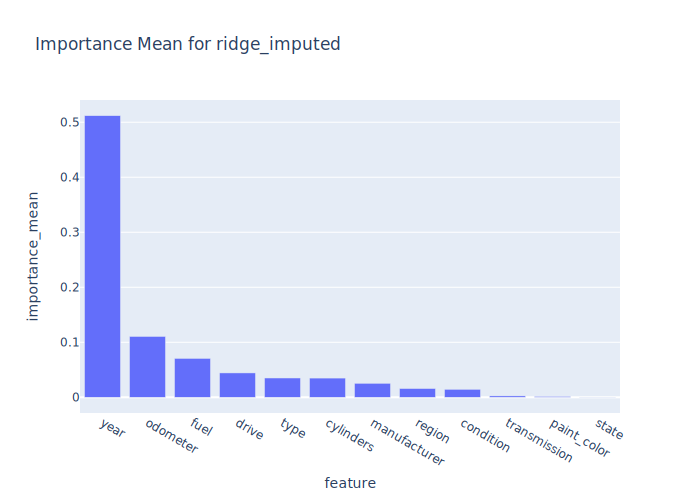

In [218]:
calc_permutation_importance(best_model, X, y, 'ridge_imputed', n_repeats=10, random_state=0)

In [219]:
calc_features_coefs(best_model)

                          Feature  Coefficient
0       numeric_transformer__year     0.687804
17   ohe_transformer__fuel_diesel     0.346525
1   numeric_transformer__odometer    -0.262017
2     numeric_transformer__year^2     0.235892
19      ohe_transformer__fuel_gas    -0.153471


Analyzing coefficients `year`, diesel `fuel` type, `odometer` (negative correlation) and gas `fuel` type (negative correlation), were the leading features.

#### Linear Regression Model
In a similar fashion to the `Ridge` model, we'll build a multiple Linear Regression with `LinearRegression` model, wrapped in a `TransformedTargetRegressor`.


In [220]:
linear_model = Pipeline([
  ('preprocessing', transformer),
  ('transformer', TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp))
])

linear_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   JamesSteinE...
                                                                                               'cylinders',
                                                                                               '10 '
                                                                                               'cylinders',
                                                                                               '12 '
                                                                                               'cylinders']]))]),
                                                  ['condition', 'cylinders']),
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'drive'])])),
                ('transformer',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

![](images/linear_imputed.png)

In [221]:
params = {
  'preprocessing__numeric_transformer__poly__degree': range(1,4)
}

best_test_mse, best_train_mse, best_model, best_params, best_score, r2, best_test_size= \
    grid_cv_search_dif_test_sizes(X, y, linear_model, params, impute_needed=True)

update_model_results('linear_regression', 'imputed', best_params, best_train_mse, best_test_mse, r2, best_test_size)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 3 candidates, totalling 15 fits
           regressor   method  \
1  linear_regression  imputed   

                                         grid_params     train_mse  \
1  {'preprocessing__numeric_transformer__poly__de...  5.651845e+07   

       test_mse       r_2  test_size  
1  5.701712e+07  0.655557        0.2  
best params = {'preprocessing__numeric_transformer__poly__degree': 3}


Permutation Importance

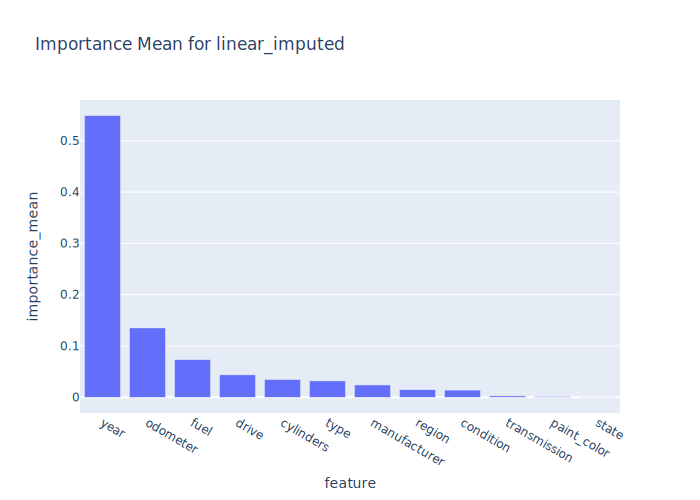

In [222]:
calc_permutation_importance(best_model, X, y, 'linear_imputed', n_repeats=10, random_state=0)

In [223]:
calc_features_coefs(best_model)


                           Feature  Coefficient
0        numeric_transformer__year     0.701713
17    ohe_transformer__fuel_diesel     0.403205
1    numeric_transformer__odometer    -0.260046
18  ohe_transformer__fuel_electric    -0.241448
2      numeric_transformer__year^2     0.240797


Analyzing coefficients `year`, diesel `fuel` type, `odometer` (negative correlation) and electric car `fuel` type (negative correlation), were the leading features.

#### Lasso Model
In a similar fashion to the `Ridge` and `LinearRegression` models, we'll build a multiple Linear Regression with the `Lasso` model, wrapped in a `TransformedTargetRegressor`.

In [224]:
lasso_model = Pipeline([
  ('preprocessing', transformer),
  ('transformer', TransformedTargetRegressor(regressor=Lasso(), func=np.log, inverse_func=np.exp))
])

lasso_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   JamesSteinE...
                                                                                               'cylinders',
                                                                                               '8 '
                                                                                               'cylinders',
                                                                                               '10 '
                                                                                               'cylinders',
                                                                                               '12 '
                                                                                               'cylinders']]))]),
                                                  ['condition', 'cylinders']),
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'drive'])])),
                ('transformer',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Lasso()))])

![](images/lasso_imputed.png)

In [225]:
params = {
  'transformer__regressor__alpha': np.logspace(-1, 5, 20),
  'transformer__regressor__max_iter': [5000],
  'preprocessing__numeric_transformer__poly__degree': range(1, 4)
}

best_test_mse, best_train_mse, best_model, best_params, best_score, r2, best_test_size = \
    grid_cv_search_dif_test_sizes(X, y, lasso_model, params, impute_needed=True)

update_model_results('lasso', 'imputed', best_params, best_train_mse, best_test_mse, r2, best_test_size)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
  regressor   method                                        grid_params  \
2     lasso  imputed  {'preprocessing__numeric_transformer__poly__de...   

      train_mse      test_mse       r_2  test_size  
2  8.737543e+07  8.601933e+07  0.480353        0.2  
best params = {'preprocessing__numeric_transformer__poly__degree': 2, 'transformer__regressor__alpha': 0.1, 'transformer__regressor__max_iter': 5000}


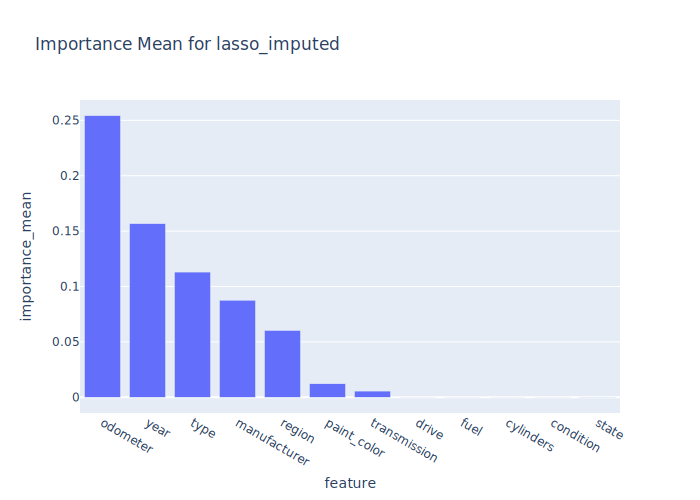

In [226]:
calc_permutation_importance(best_model, X, y, 'lasso_imputed', n_repeats=10, random_state=0)

In [227]:
calc_features_coefs(best_model, threshold=0)

                           Feature  Coefficient
1    numeric_transformer__odometer    -0.266525
0        numeric_transformer__year     0.243844
2      numeric_transformer__year^2     0.035918
8    categorical_transformer__type     0.000080
5  categorical_transformer__region     0.000066


Analyzing coefficients, `odometer` (negative correlation) and `year` were the leading features.

#### Linear Model with Feature Selection

In [228]:
linear_model_feat = Pipeline([
  ('preprocessing', transformer),
  ('feature_selection', SequentialFeatureSelector(Lasso(), n_features_to_select=4, scoring='neg_mean_squared_error')),
  ('transformer', TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp))
])

linear_model_feat

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   JamesSteinE...
                                                                   RandomSampleImputer(random_state=10)),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'drive'])])),
                ('feature_selection',
                 SequentialFeatureSelector(estimator=Lasso(),
                                           n_features_to_select=4,
                                           scoring='neg_mean_squared_error')),
                ('transformer',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

![](images/linear_imputed_fs.png)


In [229]:
params = {
  'preprocessing__numeric_transformer__poly__degree': range(1,4),
  'feature_selection__n_features_to_select': [4, 5, 6]
}

best_test_mse, best_train_mse, best_model, best_params, best_score, r2, best_test_size= \
    grid_cv_search_dif_test_sizes(X, y, linear_model_feat, params, impute_needed=True)

update_model_results('linear_regression_feat', 'imputed', best_params, best_train_mse, best_test_mse, r2, best_test_size)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
                regressor   method  \
3  linear_regression_feat  imputed   

                                         grid_params     train_mse  \
3  {'feature_selection__n_features_to_select': 6,...  7.031756e+07   

       test_mse       r_2  test_size  
3  7.043728e+07  0.574485        0.2  
best params = {'feature_selection__n_features_to_select': 6, 'preprocessing__numeric_transformer__poly__degree': 3}


Permutation Importance

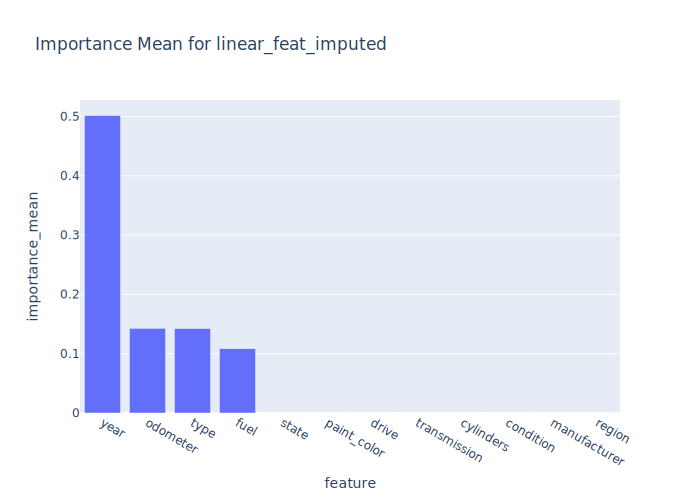

In [230]:
calc_permutation_importance(best_model, X, y, 'linear_feat_imputed', n_repeats=10, random_state=0)

In [231]:
# Get the coefficients
size = len(best_model.named_steps['transformer'].regressor_.coef_)
coefficients = best_model.named_steps['transformer'].regressor_.coef_
# Get the feature names
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()[:size]
# Combine feature names and coefficients
feature_importance = pd.DataFrame({
  'Feature': feature_names,
  'Coefficient': coefficients
})
df_f = feature_importance[abs(feature_importance['Coefficient']) > 0.00001].sort_values(by='Coefficient', ascending=False, key=abs)
print(df_f.head())

                              Feature  Coefficient
0           numeric_transformer__year     0.688216
5         numeric_transformer__year^3     0.640857
2         numeric_transformer__year^2     0.248018
1       numeric_transformer__odometer    -0.231653
3  numeric_transformer__year odometer     0.019490


Analyzing coefficients, `manufacturer` and `odometer` (negative correlation) were the leading features, along with `year`.

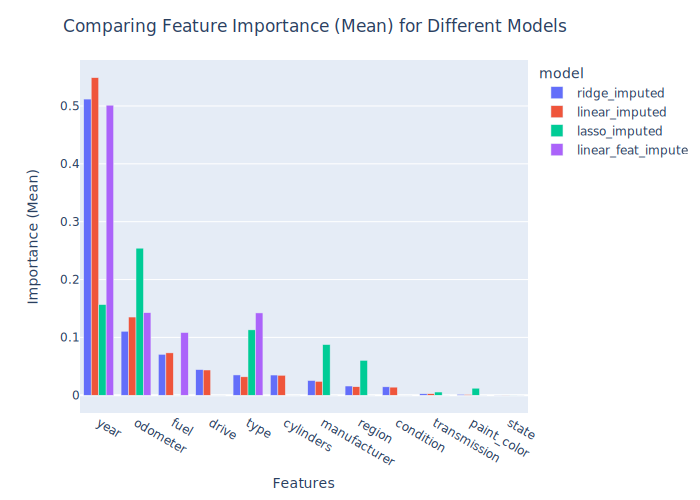

In [232]:
# Comparing Importance Mean for Different Models (Ridge, LinearRegression, Lasso)
df_im = pd.DataFrame(permutation_importance_results)
fig = px.bar(df_im, x="feature", y="importance_mean",
             color="model", barmode = 'group')
fig.update_layout(title='Comparing Feature Importance (Mean) for Different Models',
                  title_x=0.45, title_y=0.96,
                  yaxis_title='Importance (Mean)',
                  xaxis_title='Features')
fig.show()

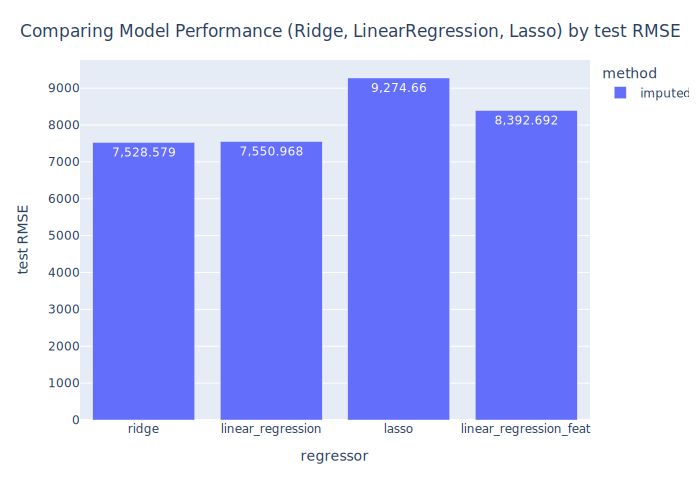

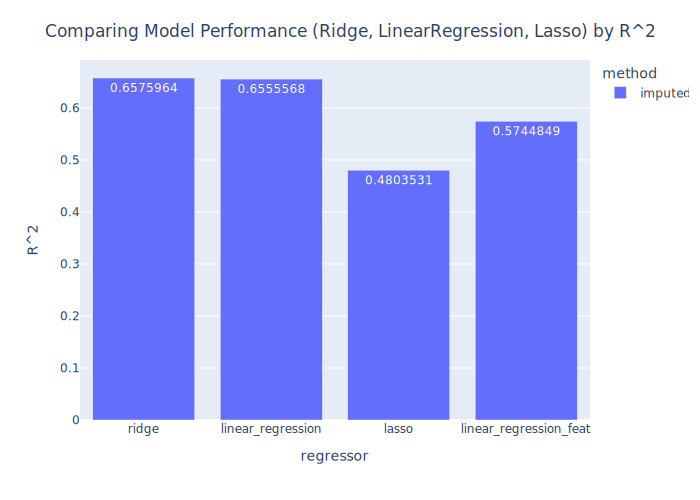

In [233]:
# Comparing Model Results (r2 / test RMSE) for Different Models (Ridge, LinearRegression, Lasso)
df3 = pd.DataFrame(model_results)
fig = px.bar(df3, x="regressor", y=np.sqrt(df3['test_mse']),
             color="method", barmode = 'group', text_auto=True)
fig.update_layout(title='Comparing Model Performance (Ridge, LinearRegression, Lasso) by test RMSE',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='test RMSE',
                  xaxis_title='regressor')
fig.show()

df3 = pd.DataFrame(model_results)
fig = px.bar(df3, x="regressor", y='r_2', color="method", barmode = 'group', text_auto=True)
fig.update_layout(title='Comparing Model Performance (Ridge, LinearRegression, Lasso) by R^2',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='R^2',
                  xaxis_title='regressor')
fig.show()

### Comparing Imputation Strategy to Drop All NaNs
Now that we optimized the best model for data that was imputated in order to keep as many records as possible, let's try and compare it to a model that we'll built on top of data without imputation - we will only use rows that don't contain NaN or missing values (as the `other` value).
The logic behind it, is that since the original data set included many NaNs for many columns, the imputation process generated many syntetic data values, that might affect the prediction results.

###### Data Preparation

In [234]:
# Dropping all NaNs from the data set
df = pd.read_csv('data/vehicles.csv')
cleanup_data = {'categories': [], 'values': []}

# cleaning duplicates
before = len(df)
print(f'data set size before removing duplicates: {before}')
df['VIN'].sort_values().value_counts().head(50)
duplicated = df.loc[df.duplicated(['year', 'manufacturer', 'condition', 'odometer', 'VIN'], keep='last')]
df = df.drop(duplicated.index, axis=0)
print(f'data set size after removing duplicates: {len(df)}\n')
cleanup_data['categories'].append('duplicates')
cleanup_data['values'].append(before - len(df))

df = df.drop(['VIN', 'id', 'size', 'model'], axis=1)

# Set boundries for price
before = len(df)
print(f'data set size before setting price boundaries: {len(df)}')
df = df[(df['price'] > 500) & (df['price'] <= 100000)]
print(f'data set size after setting price boundaries: {len(df)}\n')
cleanup_data['categories'].append('price cleanup')
cleanup_data['values'].append(before - len(df))

# Cleaning high odometer values
before = len(df)
print(f'data set size before removing high `odometer` cars: {before}')
df = df[df['odometer'] <= 400000]
print(f'data set size after removing high `odometer` cars: {len(df)}\n')
cleanup_data['categories'].append('odometer cleanup')
cleanup_data['values'].append(before - len(df))

# Keeping only clean title_status
before = len(df)
print(f'data set size before removing non-clean `title_status` values: {before}')
df = df[df['title_status'] == 'clean']
# only 1 value left in the title status column - so we can remove it for the prediction part
df.drop(['title_status'], axis=1, inplace=True)
print(f'data set size after removing non-clean `title_status` values: {len(df)}\n')
cleanup_data['categories'].append('title_status cleanup')
cleanup_data['values'].append(before - len(df))

# dropping nulls
before = len(df)
print(f'data set size before dropping all remaining NaN values: {before}')
df_no_nulls = df.dropna()
print(f'data set size before dropping all remaining NaN values: {len(df_no_nulls)}\n')
cleanup_data['categories'].append('NaN cleanup')
cleanup_data['values'].append(before - len(df_no_nulls))

# cleanning 'other' (implies missing) values from the data set
before = len(df_no_nulls)
print(f'data set size before dropping `other` values: {before}')
other_status = df_no_nulls.loc[(df_no_nulls['cylinders'] == 'other') | (df_no_nulls['type'] == 'other') | (df_no_nulls['fuel'] == 'other')]
df_no_nulls = df_no_nulls.drop(other_status.index, axis=0)
print(f'data set size after dropping `other` values: {len(df_no_nulls)}')
cleanup_data['categories'].append('other cleanup')
cleanup_data['values'].append((before - len(df_no_nulls)))

cleanup_data['categories'].append('clean records')
cleanup_data['values'].append(len(df_no_nulls))

df_no_nulls.isnull().sum()

data set size before removing duplicates: 426880
data set size after removing duplicates: 227852

data set size before setting price boundaries: 227852
data set size after setting price boundaries: 205970

data set size before removing high `odometer` cars: 205970
data set size after removing high `odometer` cars: 204101

data set size before removing non-clean `title_status` values: 204101
data set size after removing non-clean `title_status` values: 191384

data set size before dropping all remaining NaN values: 191384
data set size before dropping all remaining NaN values: 66654

data set size before dropping `other` values: 66654
data set size after dropping `other` values: 65070


region          0
price           0
year            0
manufacturer    0
condition       0
cylinders       0
fuel            0
odometer        0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

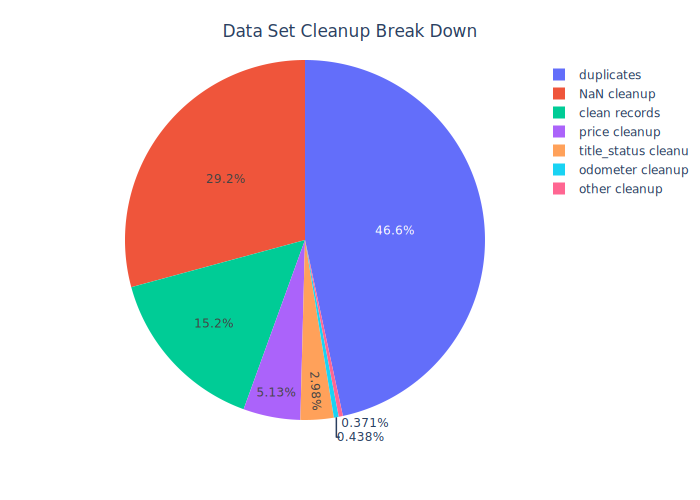

In [235]:
cleanup_data_df = pd.DataFrame(cleanup_data)
cleanup_data_df.head(10)
fig = px.pie(cleanup_data_df, values='values', names='categories')
fig.update_layout(title='Data Set Cleanup Break Down',
                  title_x=0.5, title_y=0.95)
fig.show()

We can see that after all data cleanups we are left with only `15.3%` percent of the original data set. Duplicates (`46.6%`) and NaNs (`29.2`) had together a `75.8%` share, which is a big portion of the original data.

In [236]:
X = df_no_nulls.drop('price', axis = 1)
y = df_no_nulls['price']

#### Modeling
We'll build the same models as we did before. For the preprocessing Pipelines, they will be almost the same, just without the need to impute the data since we remove all NaN values. We'll not run the Lasso Model on this data, since it showed poor performance with the imputed data.

In [237]:
cat_features = df.select_dtypes(exclude=['int', 'float'])
condition_cat = ['salvage', 'fair','good', 'excellent','like new', 'new']
cylinders_cat = ['3 cylinders', '4 cylinders', '5 cylinders', '6 cylinders', '8 cylinders', '10 cylinders', '12 cylinders']
ord_enc = OrdinalEncoder(categories=[condition_cat, cylinders_cat])

transformer1 = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=1, include_bias=False))
])

transformer2 = Pipeline(steps=[
    ('encoder', ce.JamesSteinEncoder())
])

transformer3 = Pipeline(steps=[
    ('encoder', ord_enc)
])

transformer4 = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])


numeric_features = ['year', 'odometer']
ord_enc_feat = ['condition', 'cylinders']
ohe_enc_feat = ['fuel', 'drive']
categorical_features = list(cat_features.columns)
categorical_features.remove(ord_enc_feat[0])
categorical_features.remove(ord_enc_feat[1])
categorical_features.remove(ohe_enc_feat[0])
categorical_features.remove(ohe_enc_feat[1])

transformer = ColumnTransformer(
    transformers=[
        ('numeric_transformer', transformer1, numeric_features),
        ('categorical_transformer', transformer2, categorical_features),
        ('ordinal_transformer', transformer3, ord_enc_feat),
        ('ohe_transformer', transformer4, ohe_enc_feat)
    ], remainder='passthrough'
)


#### GridSearch with different test set sizes
As we did beofre, we'll conduct a GridSearchCV to find the best hyper parameters with 3 different test set sizes `[0.2, 0.25, 0.3]`. We'll utilize the same function that we generated before for the gris search `grid_cv_search_dif_test_sizes`.

#### Ridge Model (No NaNs)

In [238]:
model_ridge_no_nans = Pipeline([
  ('preprocessing', transformer),
  ('transformer', TransformedTargetRegressor(regressor=Ridge(), func=np.log, inverse_func=np.exp))
])

model_ridge_no_nans

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   JamesSteinEncoder())]),
                                                  ['region', 'manufacturer',
                                                   'transmissio...
                                                                                               'cylinders',
                                                                                               '4 '
                                                                                               'cylinders',
                                                                                               '5 '
                                                                                               'cylinders',
                                                                                               '6 '
                                                                                               'cylinders',
                                                                                               '8 '
                                                                                               'cylinders',
                                                                                               '10 '
                                                                                               'cylinders',
                                                                                               '12 '
                                                                                               'cylinders']]))]),
                                                  ['condition', 'cylinders']),
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'drive'])])),
                ('transformer',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=Ridge()))])

![](images/ridge_no_nans.png)

In [239]:
params = {
  'transformer__regressor__alpha': np.logspace(-1, 5, 20),
  'preprocessing__numeric_transformer__poly__degree': range(1,4)
}
best_test_mse, best_train_mse, best_model, best_params, best_score, r2, best_test_size = \
    grid_cv_search_dif_test_sizes(X, y, model_ridge_no_nans, params)

update_model_results('ridge', 'drop_nulls', best_params, best_train_mse, best_test_mse, r2, best_test_size)



Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 5 folds for each of 60 candidates, totalling 300 fits
  regressor      method                                        grid_params  \
4     ridge  drop_nulls  {'preprocessing__numeric_transformer__poly__de...   

      train_mse      test_mse       r_2  test_size  
4  4.146542e+07  4.255871e+07  0.671939        0.2  
best params = {'preprocessing__numeric_transformer__poly__degree': 3, 'transformer__regressor__alpha': 615.8482110660261}


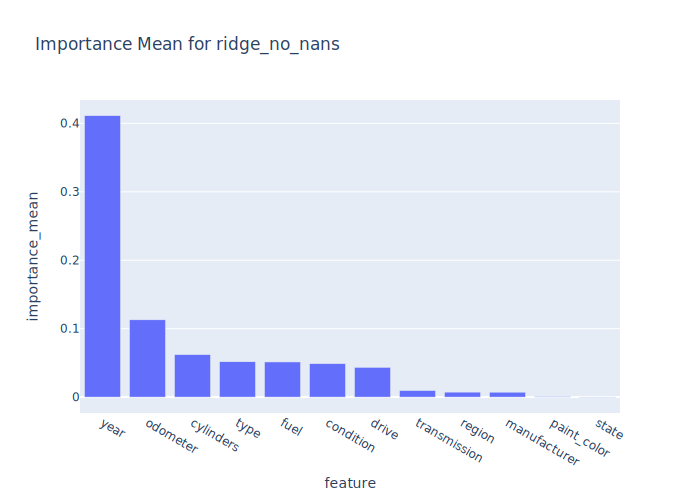

In [240]:
calc_permutation_importance(best_model, X, y, 'ridge_no_nans', n_repeats=10, random_state=0)

In [241]:
calc_features_coefs(best_model)

                          Feature  Coefficient
0       numeric_transformer__year     0.605757
1   numeric_transformer__odometer    -0.261849
2     numeric_transformer__year^2     0.250955
17   ohe_transformer__fuel_diesel     0.237049
19      ohe_transformer__fuel_gas    -0.218063


Analyzing coefficients, `year` and `odometer` (negative correlation) were the leading features, along with diesel `transmition` type and gas `fuel` (negative correlation).

#### LinearRegression Model (No NaNs)

In [242]:
linear_model_no_nans = Pipeline([
  ('preprocessing', transformer),
  ('transformer', TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp))
])
linear_model_no_nans

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   JamesSteinEncoder())]),
                                                  ['region', 'manufacturer',
                                                   'transmissio...
                                                                                               '4 '
                                                                                               'cylinders',
                                                                                               '5 '
                                                                                               'cylinders',
                                                                                               '6 '
                                                                                               'cylinders',
                                                                                               '8 '
                                                                                               'cylinders',
                                                                                               '10 '
                                                                                               'cylinders',
                                                                                               '12 '
                                                                                               'cylinders']]))]),
                                                  ['condition', 'cylinders']),
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'drive'])])),
                ('transformer',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

![](images/linear_no_nans.png)

In [243]:
params = {
  'preprocessing__numeric_transformer__poly__degree': range(1,4)
}
best_test_mse, best_train_mse, best_model, best_params, best_score, r2, best_test_size = \
    grid_cv_search_dif_test_sizes(X, y, linear_model_no_nans, params, verbose=True)

update_model_results('linear_regression', 'drop_nulls', best_params, best_train_mse, best_test_mse, r2, best_test_size)


Fitting 5 folds for each of 3 candidates, totalling 15 fits
best params for test size 0.2 = {'preprocessing__numeric_transformer__poly__degree': 3}
train_mse for test size 0.2 = 42155986.47150782
test_mse for test size 0.2 = 43084541.16351673
r2 for test size 0.2 = 0.6678853029793362
GridSearchCV best MSE for test size 0.2 = 0.6789797301695379
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best params for test size 0.25 = {'preprocessing__numeric_transformer__poly__degree': 3}
train_mse for test size 0.25 = 42088930.251074985
test_mse for test size 0.25 = 43307576.937998004
r2 for test size 0.25 = 0.6674398521159095
GridSearchCV best MSE for test size 0.25 = 0.6803375757342256
Fitting 5 folds for each of 3 candidates, totalling 15 fits
best params for test size 0.3 = {'preprocessing__numeric_transformer__poly__degree': 3}
train_mse for test size 0.3 = 42205442.872837424
test_mse for test size 0.3 = 43505055.531550564
r2 for test size 0.3 = 0.6651659093313851
GridSearchCV b

Permutation Importance of LinearRegression Model

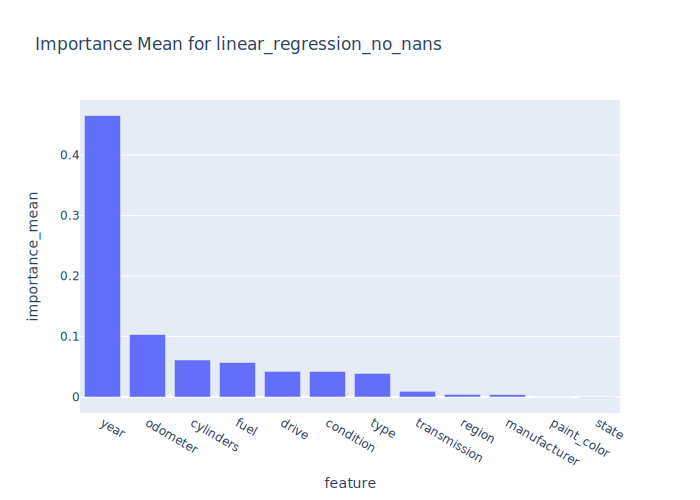

In [244]:
calc_permutation_importance(best_model, X, y, 'linear_regression_no_nans', n_repeats=10, random_state=0)

In [245]:
calc_features_coefs(best_model)

                          Feature  Coefficient
0       numeric_transformer__year     0.657555
17   ohe_transformer__fuel_diesel     0.296155
2     numeric_transformer__year^2     0.271096
1   numeric_transformer__odometer    -0.259009
19      ohe_transformer__fuel_gas    -0.236522


Analyzing coefficients, `year` and `odometer` (negative correlation) were the leading features, along with diesel `transmition` type and gas `fuel` (negative correlation).

#### LinearRegression Model with Feature Selection (No NaNs)

In [246]:
linear_model_feat_no_nans = Pipeline([
  ('preprocessing', transformer),
  ('feature_selection', SequentialFeatureSelector(Lasso(), n_features_to_select=4, scoring='neg_mean_squared_error')),
  ('transformer', TransformedTargetRegressor(regressor=LinearRegression(), func=np.log, inverse_func=np.exp))
])
linear_model_feat_no_nans

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_transformer',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['year', 'odometer']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   JamesSteinEncoder())]),
                                                  ['region', 'manufacturer',
                                                   'transmissio...
                                                 ('ohe_transformer',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['fuel', 'drive'])])),
                ('feature_selection',
                 SequentialFeatureSelector(estimator=Lasso(),
                                           n_features_to_select=4,
                                           scoring='neg_mean_squared_error')),
                ('transformer',
                 TransformedTargetRegressor(func=<ufunc 'log'>,
                                            inverse_func=<ufunc 'exp'>,
                                            regressor=LinearRegression()))])

![](images/linear_no_nans_fs.png)

In [247]:
params = {
  'preprocessing__numeric_transformer__poly__degree': range(1,4),
  'feature_selection__n_features_to_select': [4, 5, 6]

}
best_test_mse, best_train_mse, best_model, best_params, best_score, r2, best_test_size = \
    grid_cv_search_dif_test_sizes(X, y, linear_model_feat_no_nans, params)

update_model_results('linear_regression_feat', 'drop_nulls', best_params, best_train_mse, best_test_mse, r2, best_test_size)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits
                regressor      method  \
6  linear_regression_feat  drop_nulls   

                                         grid_params     train_mse  \
6  {'feature_selection__n_features_to_select': 6,...  5.974486e+07   

       test_mse       r_2  test_size  
6  6.043615e+07  0.534857        0.3  
best params = {'feature_selection__n_features_to_select': 6, 'preprocessing__numeric_transformer__poly__degree': 1}


Permutation Importance of LinearRegression Model

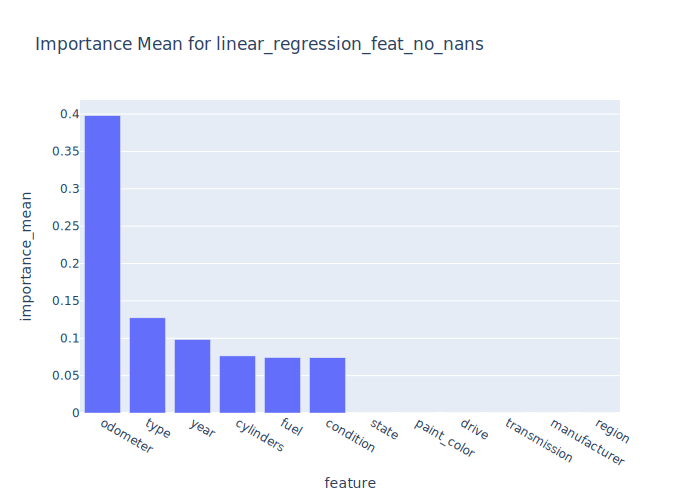

In [248]:
calc_permutation_importance(best_model, X, y, 'linear_regression_feat_no_nans', n_repeats=10, random_state=0)

In [249]:
# Get the coefficients
size = len( best_model.named_steps['transformer'].regressor_.coef_)
coefficients = best_model.named_steps['transformer'].regressor_.coef_
# Get the feature names
feature_names = best_model.named_steps['preprocessing'].get_feature_names_out()[:size]

# Combine feature names and coefficients
feature_importance = pd.DataFrame({
  'Feature': feature_names,
  'Coefficient': coefficients
})
df_f = feature_importance[abs(feature_importance['Coefficient']) > 0.00001].sort_values(by='Coefficient', ascending=False, key=abs)
print(df_f.head())

                                 Feature  Coefficient
5          categorical_transformer__type     0.600956
1          numeric_transformer__odometer    -0.391733
3  categorical_transformer__manufacturer     0.235388
0              numeric_transformer__year     0.197925
4  categorical_transformer__transmission     0.120931


Analyzing coefficients, `manufacturer` and `odometer` (negative correlation) were the leading features, along with `year`.

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

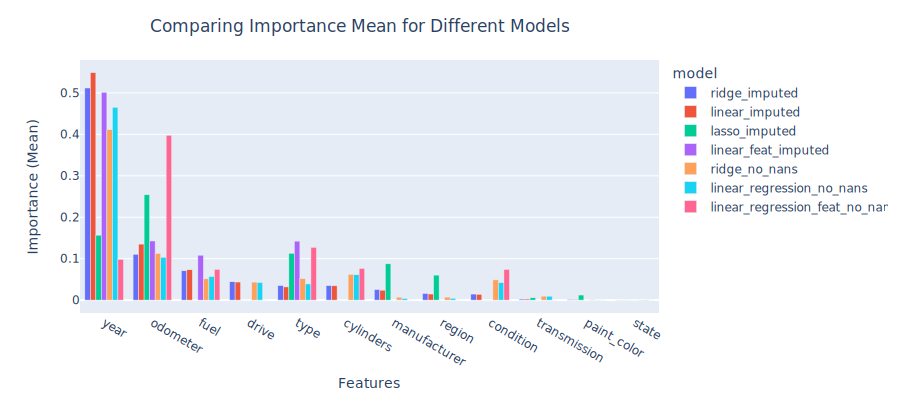

In [250]:
# Comparing Importance Mean for Different Models (Ridge, LinearRegression, Lasso)
df_im = pd.DataFrame(permutation_importance_results)
fig = px.bar(df_im, x="feature", y="importance_mean",
             color="model", barmode = 'group', width=900, height=400)
fig.update_layout(title='Comparing Importance Mean for Different Models',
                  title_x=0.4, title_y=0.95,
                  yaxis_title='Importance (Mean)',
                  xaxis_title='Features')
fig.show()

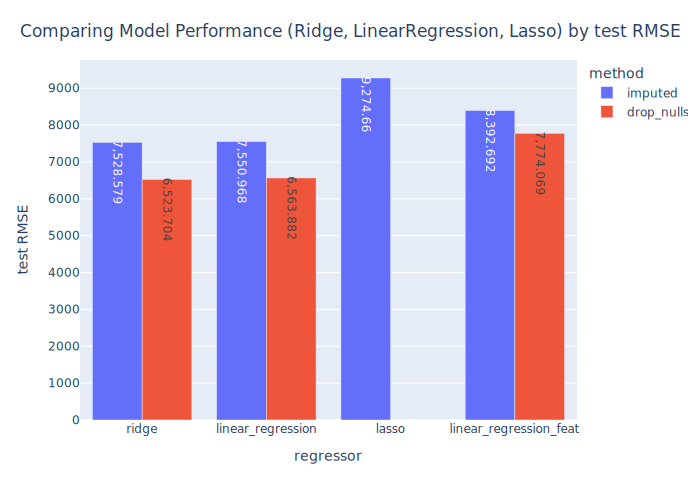

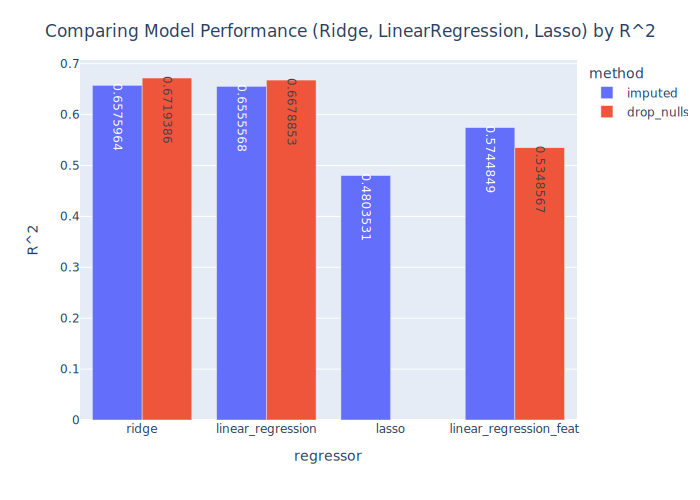

regressor      method  \
0                   ridge     imputed   
1       linear_regression     imputed   
2                   lasso     imputed   
3  linear_regression_feat     imputed   
4                   ridge  drop_nulls   
5       linear_regression  drop_nulls   
6  linear_regression_feat  drop_nulls   

                                         grid_params     train_mse  \
0  {'preprocessing__numeric_transformer__poly__de...  5.628468e+07   
1  {'preprocessing__numeric_transformer__poly__de...  5.651845e+07   
2  {'preprocessing__numeric_transformer__poly__de...  8.737543e+07   
3  {'feature_selection__n_features_to_select': 6,...  7.031756e+07   
4  {'preprocessing__numeric_transformer__poly__de...  4.146542e+07   
5  {'preprocessing__numeric_transformer__poly__de...  4.215599e+07   
6  {'feature_selection__n_features_to_select': 6,...  5.974486e+07   

       test_mse       r_2  test_size  
0  5.667950e+07  0.657596        0.2  
1  5.701712e+07  0.655557        0.2  
2  8.601933e+07  0.480353        0.2  
3  7.043728e+07  0.574485        0.2  
4  4.255871e+07  0.671939        0.2  
5  4.308454e+07  0.667885        0.2  
6  6.043615e+07  0.534857        0.3

In [251]:
df3 = pd.DataFrame(model_results)

fig = px.bar(df3, x="regressor", y=np.sqrt(df3['test_mse']),
             color="method", barmode = 'group', text_auto=True)
fig.update_layout(title='Comparing Model Performance (Ridge, LinearRegression, Lasso) by test RMSE',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='test RMSE',
                  xaxis_title='regressor')
fig.show()

fig = px.bar(df3, x="regressor", y='r_2', color="method", barmode = 'group', text_auto=True)
fig.update_layout(title='Comparing Model Performance (Ridge, LinearRegression, Lasso) by R^2',
                  title_x=0.5, title_y=0.95,
                  yaxis_title='R^2',
                  xaxis_title='regressor')
fig.show()

df3

From the above comparison, we can see that both Ridge and LinearRegression models had the best performance when working with the data set that was completely cleans from NaNs and didn't go through imputation stage. Results of the models were very similar with `r^2`=0.675 and `RMSE`~=6480. 
Lasso model didn't prodcued good results with the imputed data set (`r^2`=0.45) so we dropped it and didn't ran it on top of the no-Nans data set. We can also see that models that were built with feature selection performed worse than equivelent models with `r^2`=0.48 on both data sets (imputed and non-imputed).

### Deployment

From the above results, the data shows that the main features that drive the car price were: year, odometer, fuel type, number of cylinders and type of the car are the most important features for predicting car price.

Year and odometer were the most dominant features, so when looking at buying used cars for the delaership, we'd recommend buying newer cars and car with low odometer.
We'd also stay away from cars with high odometer and old cars (older than 10 years and up until 1980).

For collector cars (older than 1970), it's very hard to predict their price based on the year (the correlation between year and price is very weak). Hence, other factors as odometer and condition should play a bigger role.

Data also show that number of cylinders (more cylinders the higher the price), and type of the car (4wd) and the fuel type (diesel), play a role with driving the price up, so it's worth highlighting these featues when selling a used car, and pay attention to these details when pricing used cars. 